In [1]:
import tbparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("whitegrid")

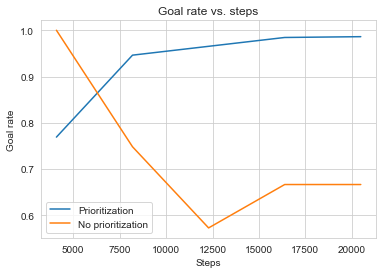

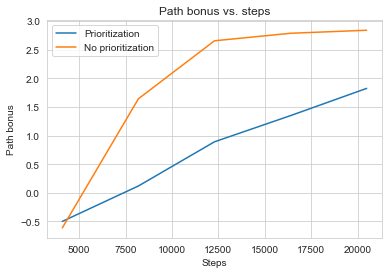

In [13]:
results = {}

mgr_x = []
mgr_y = []
mgr_h = []
mpb_x = []
mpb_y = []
mpb_h = []

for result_dir, result_key in zip([
    "./models/v11.4_compare_ppo/2023-07-19_10-59-12/",
    "./models/v11.4.1_compare_ppo_no_prioritization/2023-07-19_11-40-20/"
], [
    "Prioritization",
    "No prioritization",
]):
    summary = tbparse.SummaryReader(result_dir + "/tensorboard")
    df = summary.scalars
    tags = df['tag'].unique()
    goal_rates = {}
    path_bonuses = {}
    step_numbers = [4096, 8192, 12288, 16384, 20480]
    for tag in tags:
        if 'goal rate' in tag:
            goal_rates[tag] = df[df['tag'] == tag]['value'].values
        elif 'path bonus' in tag:
            path_bonuses[tag] = df[df['tag'] == tag]['value'].values
    results[result_key] = {
        'goal_rates': goal_rates,
        'path_bonuses': path_bonuses,
    }
    mean_goal_rate = np.mean(list(results[result_key]['goal_rates'].values()), axis=0)
    mean_path_bonus = np.mean(list(results[result_key]['path_bonuses'].values()), axis=0)
    mgr_x.extend(step_numbers)
    mgr_y.extend(mean_goal_rate)
    mgr_h.extend([result_key] * len(step_numbers))
    mpb_x.extend(step_numbers)
    mpb_y.extend(mean_path_bonus)
    mpb_h.extend([result_key] * len(step_numbers))

plt.title("Goal rate vs. steps")
plt.ylabel("Goal rate")
plt.xlabel("Steps")
sns.lineplot(x=mgr_x, y=mgr_y, hue=mgr_h)
plt.show()

plt.title("Path bonus vs. steps")
plt.ylabel("Path bonus")
plt.xlabel("Steps")
sns.lineplot(x=mpb_x, y=mpb_y, hue=mpb_h)
plt.show()

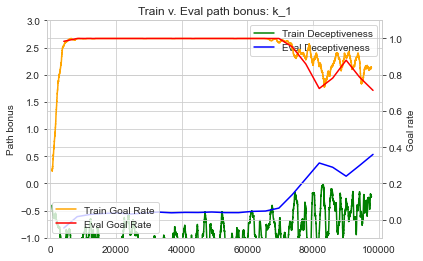

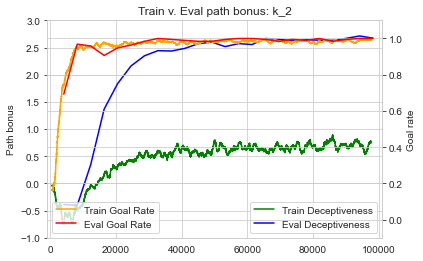

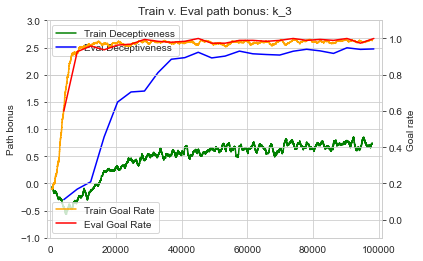

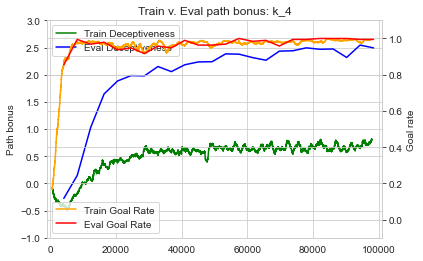

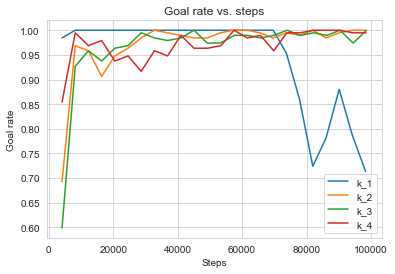

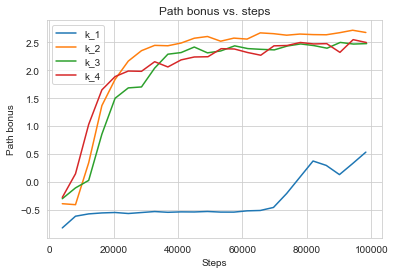

In [8]:
# Comparing numbers of layers

import os


results = {}

mgr_x = []
mgr_y = []
mgr_h = []
mpb_x = []
mpb_y = []
mpb_h = []

for result_dir in sorted(os.listdir("models/v12_different_layer_counts/")):
    result_key = result_dir
    root = "models/v12_different_layer_counts/" + result_dir
    dfs = []
    for d in sorted(os.listdir(root)):
        summary = tbparse.SummaryReader(f"{root}/{d}/tensorboard")
        df = summary.scalars
        dfs.append(df)
    if result_dir == 'k_1':
        dfs = dfs[-1:]
    df = pd.concat(dfs, axis=0)
    tags = df['tag'].unique()
    goal_rates = {}
    path_bonuses = {}
    for tag in tags:
        if 'goal rate' in tag:
            goal_rates[tag] = df[df['tag'] == tag]['value'].values
        elif 'path bonus' in tag:
            path_bonuses[tag] = df[df['tag'] == tag]['value'].values
    step_numbers = df[df['tag'] == tags[0]]['step'].values
    results[result_key] = {
        'goal_rates': goal_rates,
        'path_bonuses': path_bonuses,
    }
    mean_goal_rate = np.mean(list(results[result_key]['goal_rates'].values()), axis=0)
    mean_path_bonus = np.mean(list(results[result_key]['path_bonuses'].values()), axis=0)

    train_pb_x = (df[df['tag'] == 'Reward/path_bonus_sum']['step'].values)
    train_pb_y = (df[df['tag'] == 'Reward/path_bonus_sum']['value'].values)
    train_pb_x, train_pb_y = zip(*sorted(zip(train_pb_x, train_pb_y)))
    train_gr_x = (df[df['tag'] == 'Reward/goal_reached']['step'].values)
    train_gr_y = (df[df['tag'] == 'Reward/goal_reached']['value'].values)
    train_gr_x, train_gr_y = zip(*sorted(zip(train_gr_x, train_gr_y)))

    plt.title("Train v. Eval path bonus: " + result_key)
    rollK = 1000
    roll = lambda arr: np.convolve(arr, np.ones(rollK), 'valid') / rollK
    plt.plot(roll(train_pb_x), roll(train_pb_y), label="Train Deceptiveness", color='green')
    # sort by step number
    plt.plot(*zip(*sorted(zip(step_numbers, mean_path_bonus))), label="Eval Deceptiveness", color='blue')
    plt.ylabel("Path bonus")
    plt.legend()
    plt.ylim(-1.0, 3.0)
    plt.xlim(-1000, 101000)
    ax2 = plt.twinx()
    # plot goal rate
    ax2.plot(roll(train_gr_x), roll(train_gr_y), label="Train Goal Rate", color='orange')
    ax2.plot(*zip(*sorted(zip(step_numbers, mean_goal_rate))), label="Eval Goal Rate", color='red')
    ax2.set_ylabel("Goal rate")
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    plt.show()

    n = len(mean_goal_rate)
    mgr_x.extend(step_numbers)
    mgr_y.extend(mean_goal_rate)
    mgr_h.extend([result_key] * n)
    mpb_x.extend(step_numbers)
    mpb_y.extend(mean_path_bonus)
    mpb_h.extend([result_key] * n)

plt.title("Goal rate vs. steps")
plt.ylabel("Goal rate")
plt.xlabel("Steps")
sns.lineplot(x=mgr_x, y=mgr_y, hue=mgr_h)
plt.show()

plt.title("Path bonus vs. steps")
plt.ylabel("Path bonus")
plt.xlabel("Steps")
sns.lineplot(x=mpb_x, y=mpb_y, hue=mpb_h)
plt.show()

# Generalized model-loading code

In [2]:
# Recursively import a folder

import os
import tqdm
import pickle


def get_dataframes_by_key(source_folder):
    dataframes_by_key = {}

    for root, dirs, files in tqdm.tqdm(sorted(os.walk(source_folder)), desc="Loading Tensorboard logs..."):
        if 'model.pt' in files:
            # Load data from this directory
            # Remove the "date" subfolder (in case of multiple runs)
            key = root[len(source_folder):]
            key = key[:key.rfind('/')]

            summary = tbparse.SummaryReader(root + "/tensorboard")
            df = summary.scalars
            dataframes_by_key[key] = dataframes_by_key.get(key, []) + [df]

    return dataframes_by_key

# dataframes_by_key_v27_base = get_dataframes_by_key("models/v27_trials/")
# dataframes_by_key_v28_ablation = get_dataframes_by_key("models/v28_ablation/")
# dataframes_by_key_v29_alt_graph_models_no_prioritization = get_dataframes_by_key("models/v29_alt_graph_models_no_prioritized_training/")
dataframes_by_key_v29_alt_graph_models_no_prioritization_continued = get_dataframes_by_key("models/v29_alt_graph_models_no_prioritized_training_continued/")

with open("learning_curves_v27_trials.pkl", "rb") as f:
    dataframes_by_key_v27_base = pickle.load(f)

with open("learning_curves_v28_ablation.pkl", "rb") as f:
    dataframes_by_key_v28_ablation = pickle.load(f)

with open("learning_curves_v29_alt_graph_models_no_prioritization.pkl", "rb") as f:
    dataframes_by_key_v29_alt_graph_models_no_prioritization = pickle.load(f)

Loading Tensorboard logs...: 100%|██████████| 201/201 [11:33<00:00,  3.45s/it]


In [3]:
with open("learning_curves_v29_alt_graph_models_no_prioritization_continued_5x256.pkl", "wb") as f:
    pickle.dump(dataframes_by_key_v29_alt_graph_models_no_prioritization_continued, f)

In [17]:
# import pickle

# with open("learning_curves_v27_trials.pkl", "wb") as f:
#     pickle.dump(dataframes_by_key_v27_base, f)

# with open("learning_curves_v28_ablation.pkl", "wb") as f:
#     pickle.dump(dataframes_by_key_v28_ablation, f)

# with open("learning_curves_v29_alt_graph_models_no_prioritization.pkl", "wb") as f:
#     pickle.dump(dataframes_by_key_v29_alt_graph_models_no_prioritization, f)

In [8]:
hierarchy = {
    deception_type: {
        depth: [
            df for (key, df) in dataframes_by_key_v27_base.items()
            if 'graph_depth={}'.format(depth) in key and f'/sage/{deception_type}/' in key
        ]
        for depth in [1, 2, 4, 8]
    }
    for deception_type in ['exaggeration', 'ambiguity']
}

In [4]:
# comparisons = {
#     deception_type: {
#         "Baseline": [
#             dataframes_by_key_v27_base[
#                 f"/sage/{deception_type}/distance_metric='shortest_path'_graph_depth={nlayers}_feed_forward_layers={nlayers}_seed={i}"
#             ][0]
#             for i in range(5)
#         ],
#         "No PPO": [dataframes_by_key_v28_ablation[f'no_ppo_{deception_type}_{nlayers}_seed={i}'][0] for i in range(5)],
#         "No prioritized training": [dataframes_by_key_v28_ablation[f'no_prioritized_training_{deception_type}_{nlayers}_seed={i}'][0] for i in range(5)],
#     }
#     for (deception_type, nlayers) in [('ambiguity', 2), ('exaggeration', 4)]
# }

# In this case, I trained for a long time but accidentally started on the wrong "step".
def concatenate_dfs(dfs: list):
    # Add 256 * 5 * 96 - 4 * 96 to the step number
    # new_df_1 = dfs[1].copy()
    # new_df_1['step'] = new_df_1['step'] + 256 * 4 * 96 - 4 * 96
    return pd.concat(
        [dfs[0], dfs[1]]
    )

comparisons = {
    deception_type: {
        "GraphSAGE": [concatenate_dfs(dataframes_by_key_v29_alt_graph_models_no_prioritization_continued[f'gnn.sage_{deception_type}_{nlayers}_seed={i}']) for i in range(1, 5)],
        "GIN": [concatenate_dfs(dataframes_by_key_v29_alt_graph_models_no_prioritization_continued[f'gnn.gin_{deception_type}_{nlayers}_seed={i}']) for i in range(1, 5)],
        "GAT": [concatenate_dfs(dataframes_by_key_v29_alt_graph_models_no_prioritization_continued[f'gnn.gat_{deception_type}_{nlayers}_seed={i}']) for i in range(1, 5)],
        "GCN": [concatenate_dfs(dataframes_by_key_v29_alt_graph_models_no_prioritization_continued[f'gnn.gcn_{deception_type}_{nlayers}_seed={i}']) for i in range(1, 5)],
    }
    for (deception_type, nlayers) in [('ambiguity', 2), ('exaggeration', 4)]
}

In [8]:
# Create plot with confidence intervals

def create_confidence_intervals_plot(dataframe_dict, moving_average_k):
    # Choose the first dataframe to get the tags
    tags = next(iter(dataframe_dict.values()))[0][0]['tag'].unique()
    for tag in tags:
        if 'Held-out' in tag:
            continue
        steps = []
        values = []
        labels = []
        for key in tqdm.tqdm(dataframe_dict, desc=f"Processing ..."):
            for df, in dataframe_dict[key]:
                steps.append(df[df['tag'] == tag]['step'].values)
                values.append(df[df['tag'] == tag]['value'].values)
                steps[-1] = np.convolve(steps[-1], np.ones(moving_average_k) / moving_average_k, mode='valid')[::moving_average_k]
                values[-1] = np.convolve(values[-1], np.ones(moving_average_k) / moving_average_k, mode='valid')[::moving_average_k]
                labels.append([key] * len(steps[-1]))

        steps = np.concatenate(steps)
        values = np.concatenate(values)
        labels = np.concatenate(labels)

        print("Plotting values")

        # Plot confidence intervals with Seaborn
        plt.title(f"Confidence intervals for {tag}")
        sns.lineplot(x=steps, y=values, hue=labels, errorbar='ci')
        plt.legend()
        plt.show()


Processing ...: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


(7680,) (7680,) (7680,)
Plotting values


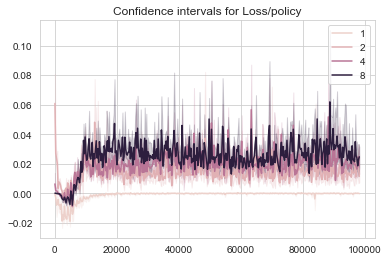

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


(7680,) (7680,) (7680,)
Plotting values


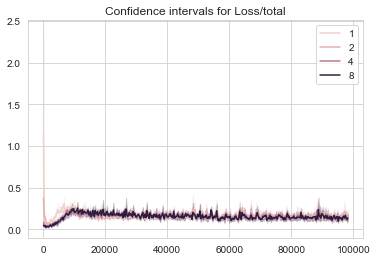

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


(7680,) (7680,) (7680,)
Plotting values


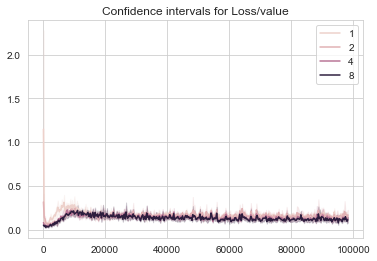

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


(7680,) (7680,) (7680,)
Plotting values


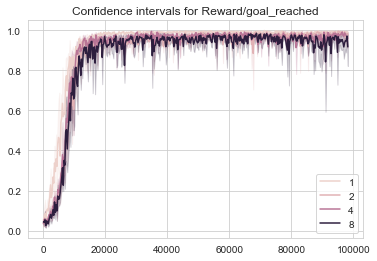

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


(7680,) (7680,) (7680,)
Plotting values


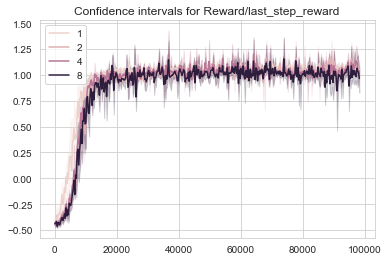

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


(7680,) (7680,) (7680,)
Plotting values


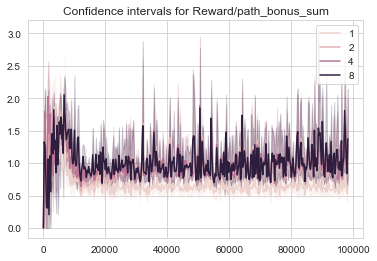

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


(7680,) (7680,) (7680,)
Plotting values


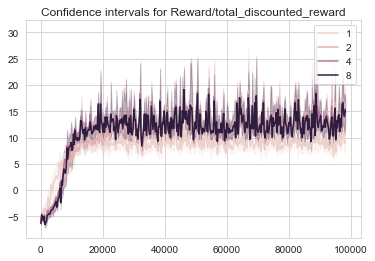

Processing ...: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


(7680,) (7680,) (7680,)
Plotting values


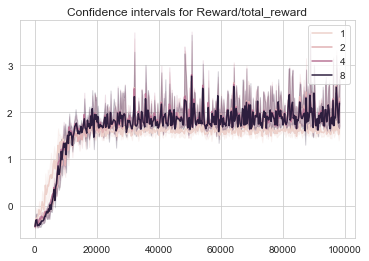

In [38]:
create_confidence_intervals_plot(
    hierarchy['ambiguity'], 256
)

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


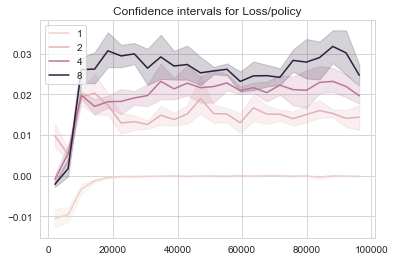

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


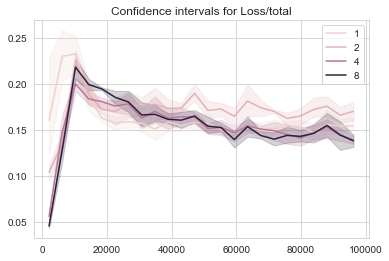

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


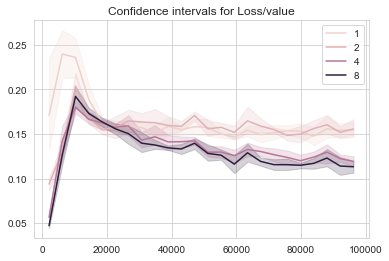

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


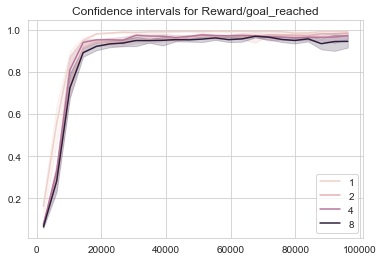

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


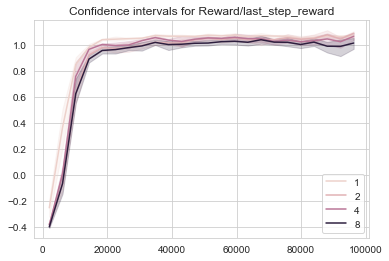

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


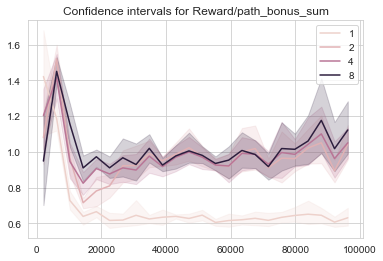

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


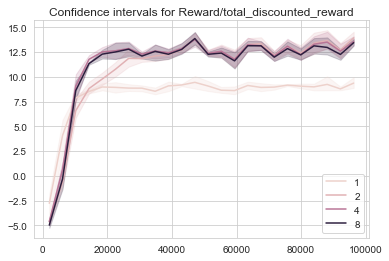

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


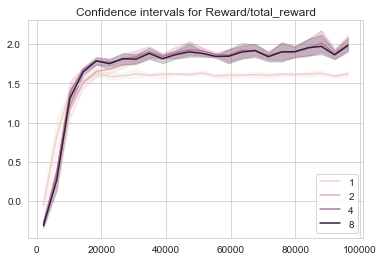

In [43]:
create_confidence_intervals_plot(
    hierarchy['ambiguity'], 4096
)

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


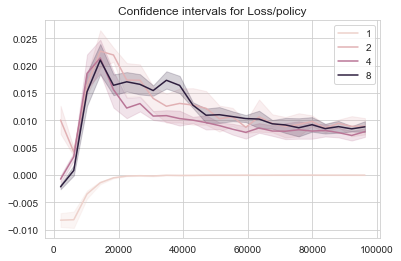

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


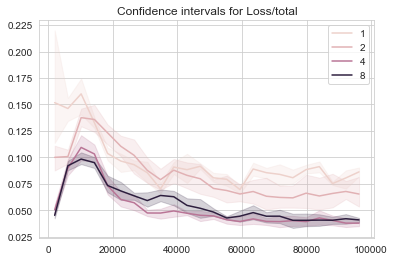

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


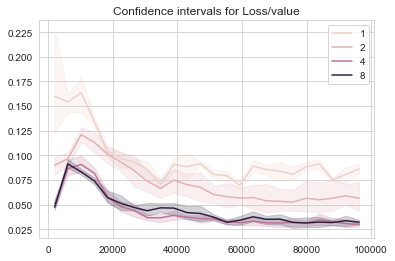

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


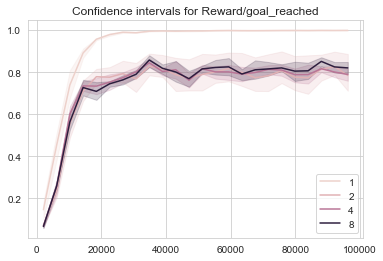

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Plotting values


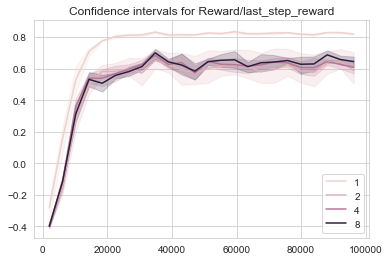

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Plotting values


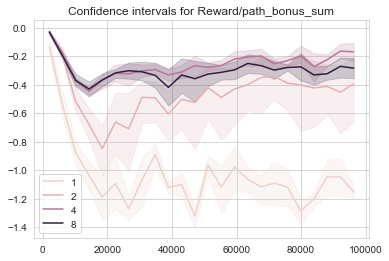

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Plotting values


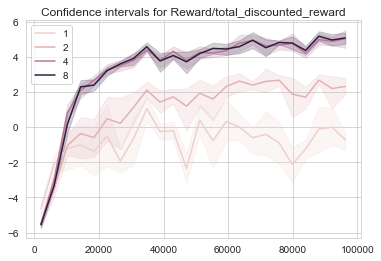

Processing ...: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Plotting values


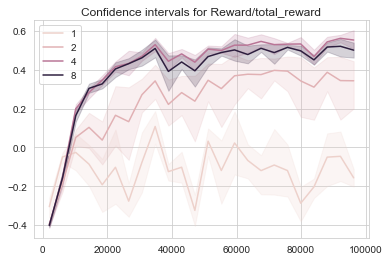

In [42]:
create_confidence_intervals_plot(
    hierarchy['exaggeration'], 4096
)

In [5]:
# Create plot with confidence intervals

def create_confidence_intervals_plot_for_held_out(dataframe_dict, moving_average_k, title, combine=False):
    # Choose the first dataframe to get the tags
    tags = dataframe_dict[list(dataframe_dict.keys())[0]][0][0]['tag'].unique()
    tag_content = {
        # 'Goal rate': ([], [], []),
        # 'Deception score': ([], [], []),
    }
    for tag in tags:
        if 'Held-out' not in tag:
            continue
        
        if combine:
            tag_name = 'Goal rate' if 'goal rate' in tag else 'Deception score'
        else:
            tag_name = tag
        tc = tag_content.get(tag_name, ([], [], []))
        steps, values, labels = tc
        for key in dataframe_dict:
            for df, in dataframe_dict[key]:
                steps.append(df[df['tag'] == tag]['step'].values)
                values.append(df[df['tag'] == tag]['value'].values)
                steps[-1] = np.convolve(steps[-1], np.ones(moving_average_k) / moving_average_k, mode='valid')[::moving_average_k]
                values[-1] = np.convolve(values[-1], np.ones(moving_average_k) / moving_average_k, mode='valid')[::moving_average_k]
                labels.append([key] * len(steps[-1]))
        tag_content[tag_name] = (steps, values, labels)

    for tag, (steps, values, labels) in tag_content.items():
        steps = np.concatenate(steps)
        values = np.concatenate(values)
        labels = np.concatenate(labels)

        # Plot confidence intervals with Seaborn
        plt.title(f"Confidence intervals for {tag.lower()}: {title}")
        # use default color palette
        sns.lineplot(x=steps, y=values, hue=labels, errorbar='ci')
        plt.legend()
        out_file = 'figures/model_size_comparison/auto_' + tag.lower() + '_' + title.lower().replace(" ", "_") + '.png'
        if not os.path.exists(os.path.dirname(out_file)):
            os.makedirs(os.path.dirname(out_file))
        plt.savefig(out_file)
        plt.show()


In [19]:
plt.rcParams['figure.dpi'] = 100

In [ ]:
create_confidence_intervals_plot_for_held_out(
    {"Layers: " + str(key): value for key, value in hierarchy['ambiguity'].items()},
    1,
    title='Ambiguity objective'
)

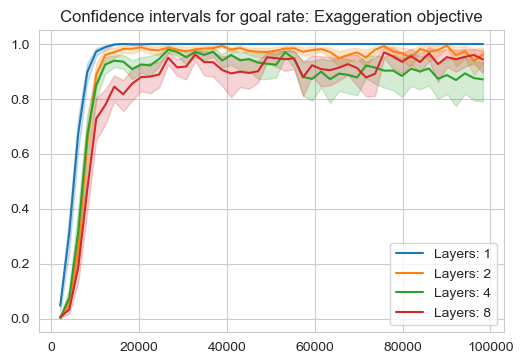

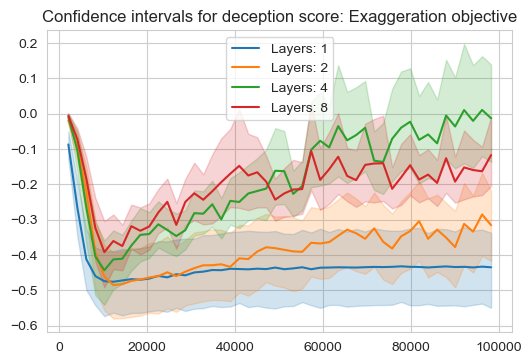

In [98]:
create_confidence_intervals_plot_for_held_out(
    {"Layers: " + str(key): value for key, value in hierarchy['exaggeration'].items()},
    1,
    title='Exaggeration objective'
)

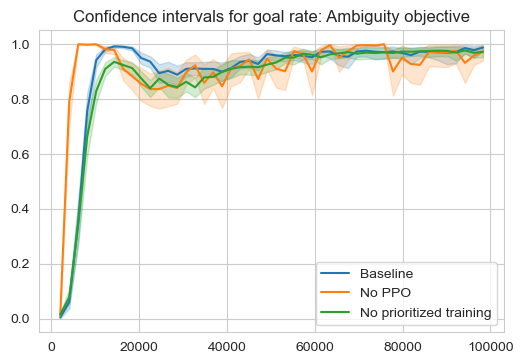

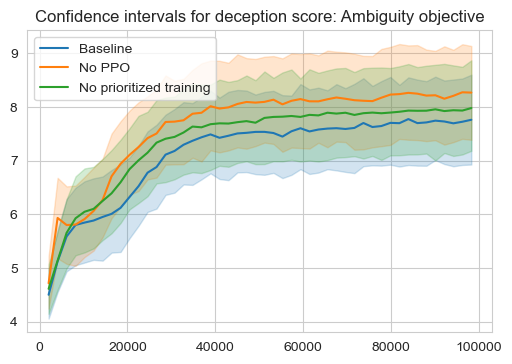

In [95]:
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['ambiguity'].items()}, 1, "Ambiguity objective"
)

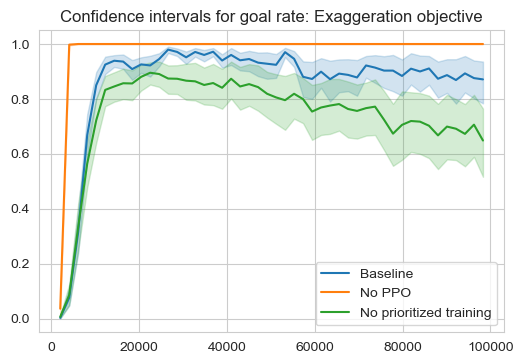

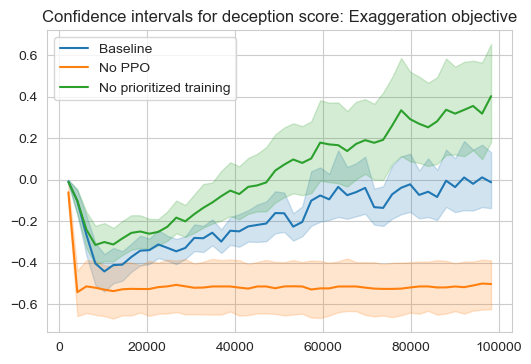

In [96]:
plt.rcParams['figure.dpi'] = 100
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['exaggeration'].items()}, 1, "Exaggeration objective"
)

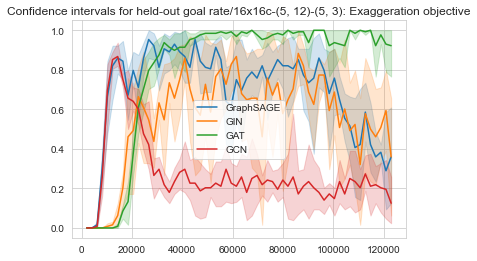

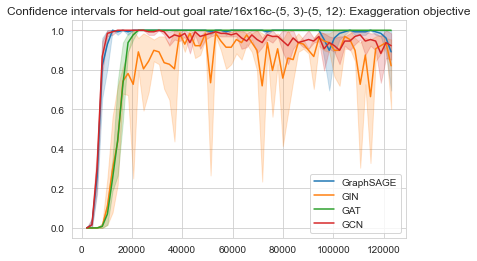

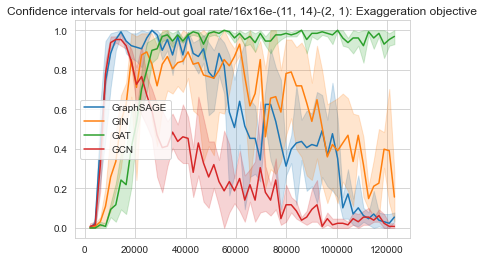

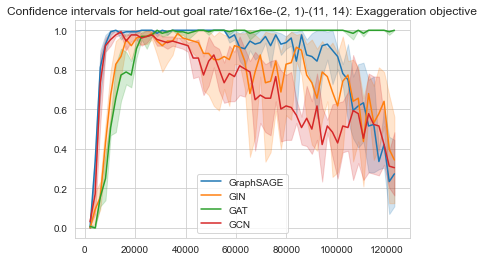

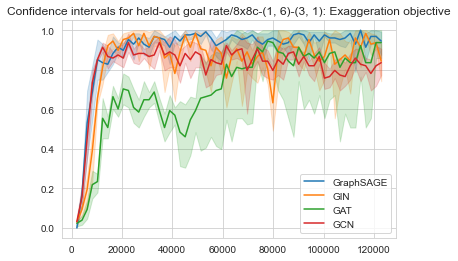

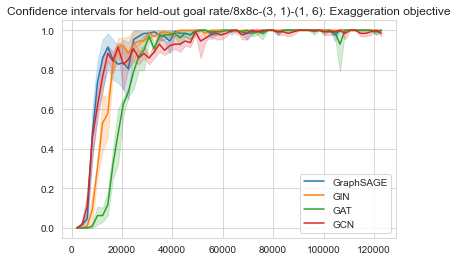

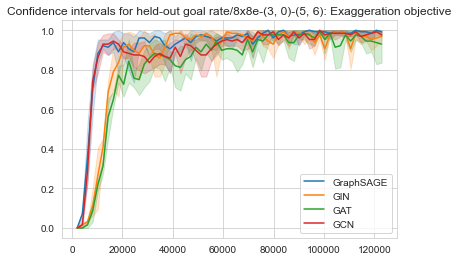

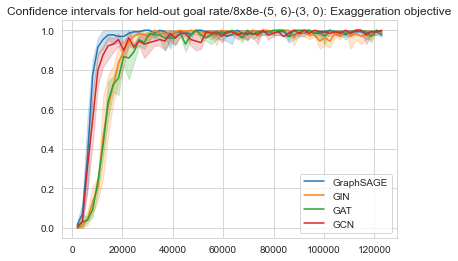

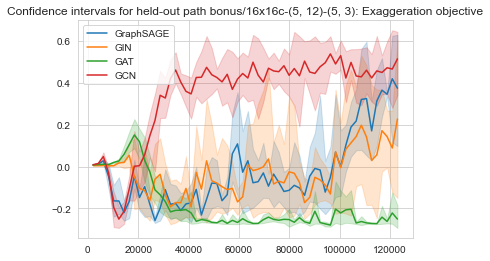

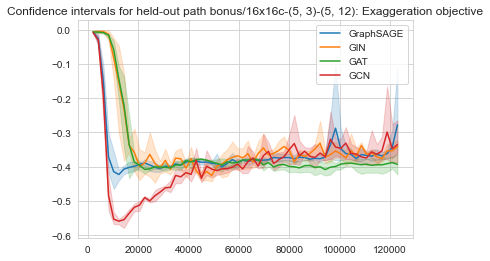

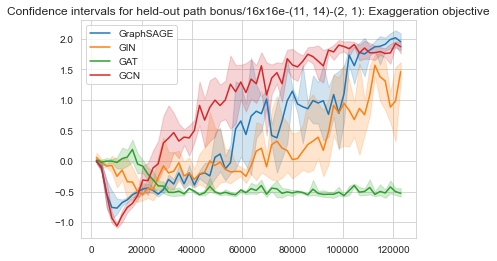

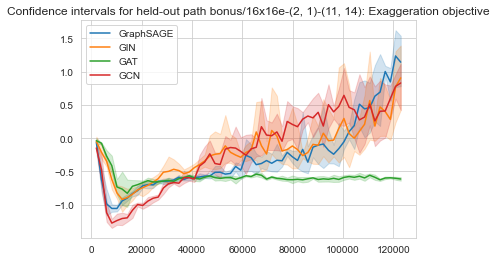

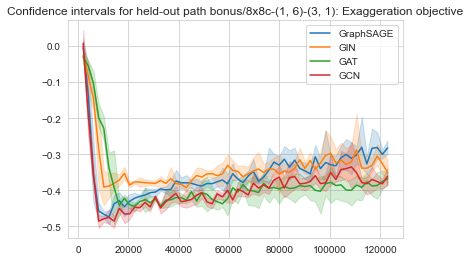

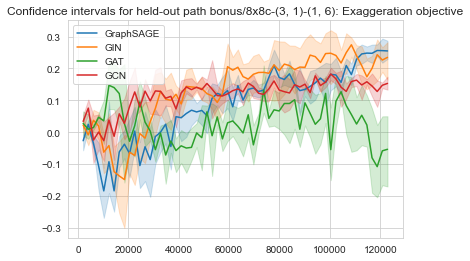

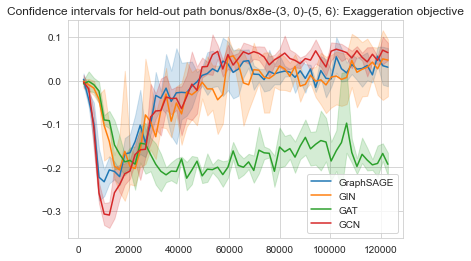

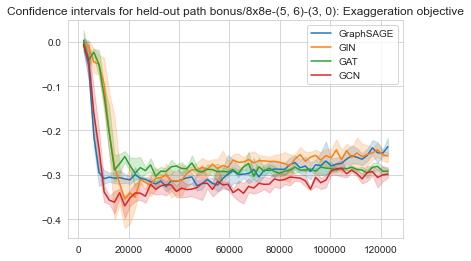

In [6]:
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['exaggeration'].items()
}, 1, "Exaggeration objective")

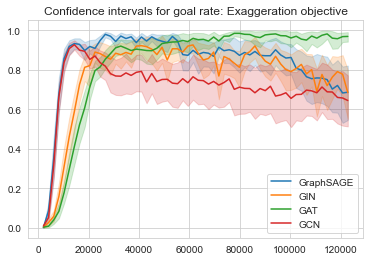

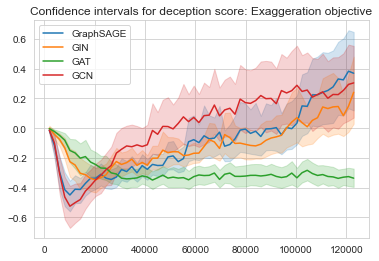

In [7]:
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['exaggeration'].items()
}, 1, "Exaggeration objective", combine=True)

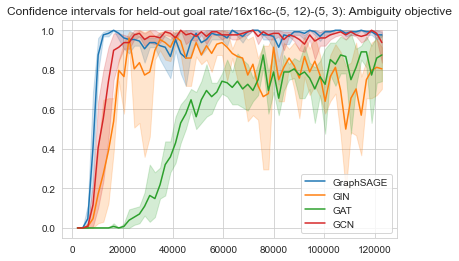

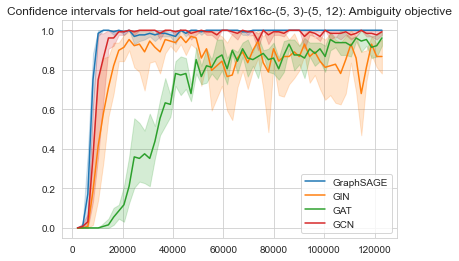

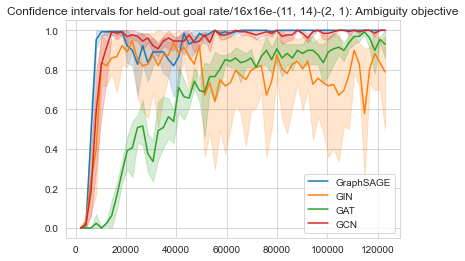

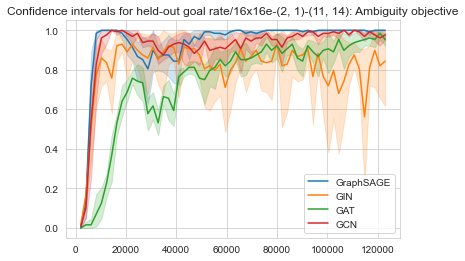

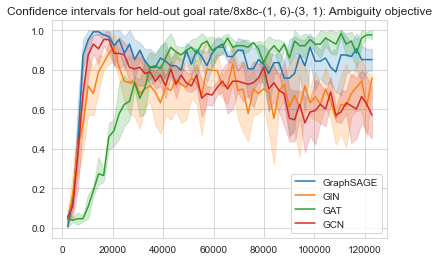

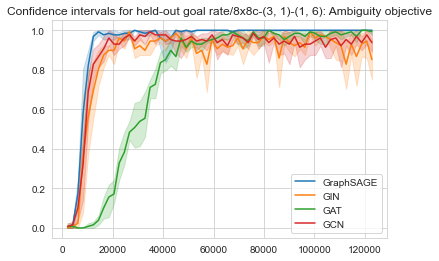

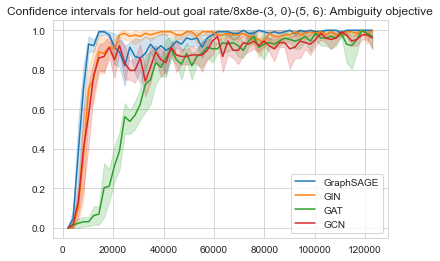

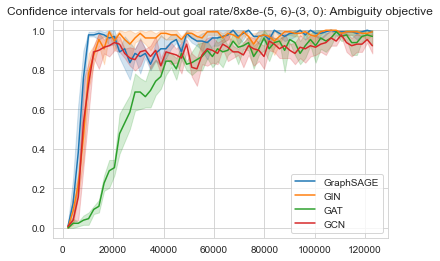

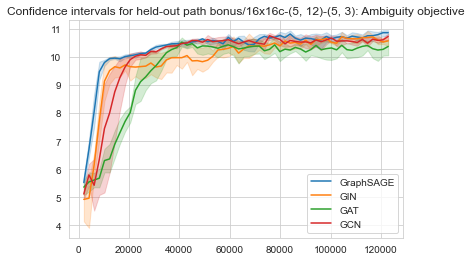

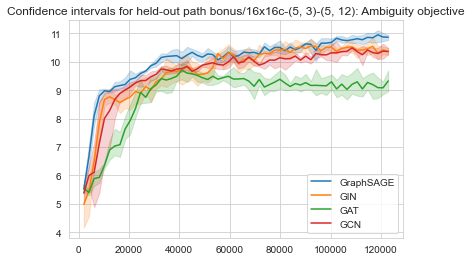

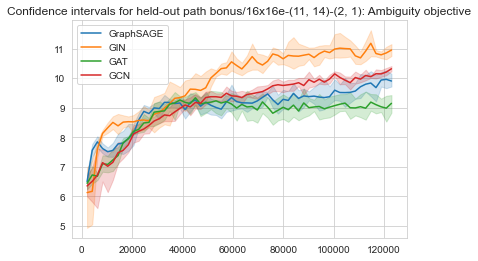

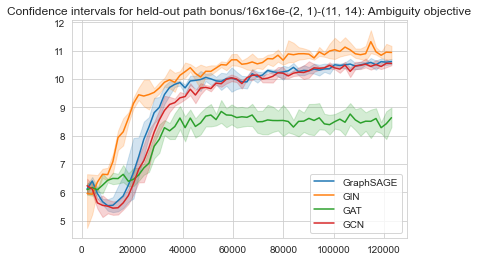

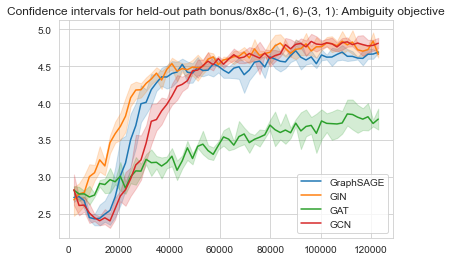

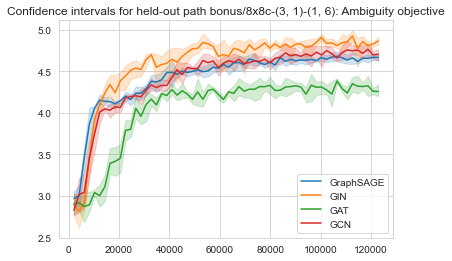

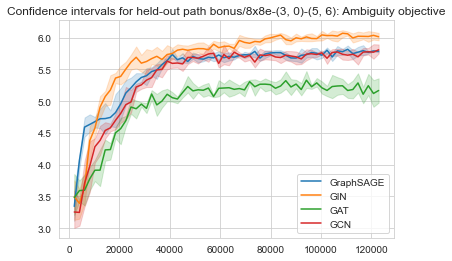

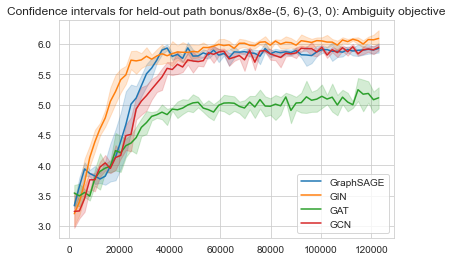

In [8]:
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['ambiguity'].items()
}, 1, "Ambiguity objective")

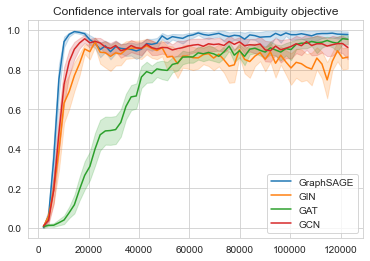

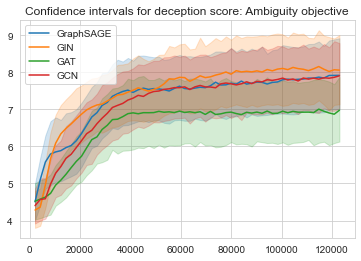

In [9]:
create_confidence_intervals_plot_for_held_out(
    {k: [[vv] for vv in v] for k, v in comparisons['ambiguity'].items()
}, 1, "Ambiguity objective", combine=True)